# Import

In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid


# params

In [5]:
DEVICE = "cpu"
ROOT = os.getcwd()
ENV_NAME = 'BipedalWalker-v3'
EXP_NAME = f'{ENV_NAME}.continuous'
OUTPUT = os.path.join(ROOT, 'output', EXP_NAME)
NORMALIZER_FILE = os.path.join(OUTPUT, 'normalizer.pickle')

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)


# test model

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 14.76it/s]

sample action = [-0.5682827  -0.37812355  0.92568976 -0.30126354], shape = (4,)


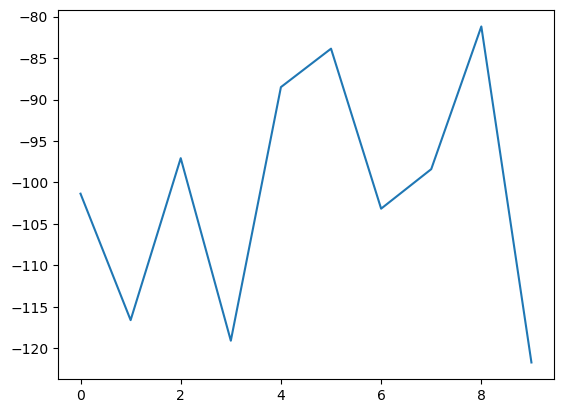

In [7]:
env = gym.make(ENV_NAME)
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)


print(f'sample action = {action}, shape = {action.shape}')
sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# model

In [34]:
class LinearNet(nn.Module):

    def __init__(self, input_size, output_size, hidden_size = 64) -> None:
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        if torch.is_tensor(X) == False: 
            X = torch.tensor(X).float()
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.fc3(X)
    

In [78]:
class PPOAgent():

    def __init__(self, 
            env: gym.Env
        ):

        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        #hyperparams
        self.timesteps_per_batch = 4500
        self.max_timesteps_per_episode = 1600
        self.gamma = 0.95
        self.n_updates_per_iterations = 5
        self.clip = 0.2
        self.lr = 5e-3

        self.avg_score = deque(maxlen=100)

        self.actor = LinearNet(self.state_size, self.action_size)
        self.optimA = torch.optim.Adam(self.actor.parameters(), lr = self.lr)

        self.critic = LinearNet(self.state_size, 1)
        self.optimC = torch.optim.Adam(self.critic.parameters(), lr = self.lr)

        #create variable matrix
        # NOTE: study covariance variable, fill with 0.5 values
        self.covariance_variable = torch.full(size = (self.action_size,), fill_value = 0.5)
        self.covariance_matrix = torch.diag(self.covariance_variable)

    def get_action(self, observation):
        mean = self.actor(observation)
        distribution = torch.distributions.MultivariateNormal(mean, self.covariance_matrix)
        action = distribution.sample()
        log_prob = distribution.log_prob(action)

        return action.detach().numpy(), log_prob.detach()
    
    def compute_returns(self, batch_rewards):
        batch_returns = []
        for ep_rewards in reversed(batch_rewards):
            discounted_rewards = 0

            for reward in reversed(ep_rewards):
                discounted_rewards = reward + discounted_rewards * self.gamma
                batch_returns.insert(0, discounted_rewards)
        batch_returns = torch.tensor(batch_returns).float()

        return batch_returns
    
    def evaluate(self, batch_observations, batch_actions):
        mean = self.actor(batch_observations)

        distribution = torch.distributions.MultivariateNormal(mean, self.covariance_matrix)
        
        log_probs = distribution.log_prob(batch_actions)

        values = self.critic(batch_observations).squeeze()

        return values, log_probs

    def rollout(self):
        batch_observations = []
        batch_actions = []
        batch_log_probs = []
        batch_rewards = []
        batch_returns = []
        batch_lengths = [] # episodic lengths in batch

        t = 0

        while t < self.timesteps_per_batch:

            episodic_rewards= []

            observation, info = self.env.reset()

            for ep_t in range(self.max_timesteps_per_episode):

                batch_observations.append(observation)

                action, log_prob = self.get_action(observation)
                observation, reward, terminated, truncated, info = self.env.step(action)

                episodic_rewards.append(reward)
                batch_actions.append(action)
                batch_log_probs.append(log_prob)

                if terminated or truncated: break
            
            t += ep_t

            self.avg_score.append(np.sum(episodic_rewards))
            batch_lengths.append(ep_t + 1)
            batch_rewards.append(episodic_rewards)

        batch_observations = torch.tensor(batch_observations).float()
        batch_actions = torch.tensor(batch_actions).float()
        batch_log_probs = torch.tensor(batch_log_probs).float()
        batch_returns = self.compute_returns(batch_rewards)

        return batch_observations, batch_actions, batch_log_probs, batch_returns, batch_lengths

    def learn(self, training_epochs = int(1e5)):
        
        loop = tqdm(range(training_epochs))
        ep_rewards = []

        t_so_far = 0

        for epoch in loop:
            batch_observations, batch_actions, batch_log_probs, batch_returns, batch_lengths = self.rollout()
            # print('batch observations = ', batch_observations.shape)
            # print('batch actions = ', batch_actions.shape)
            # print('batch log probs = ', batch_log_probs.shape)
            # print('batch returns = ', batch_returns.shape)
            # print('batch lengths = ', len(batch_returns))

            values, _ = self.evaluate(batch_observations, batch_actions)

            advantage = batch_returns - values.detach()

            #normalization for numerical stability
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-10)

            for _ in range(self.n_updates_per_iterations):
                current_values, current_log_probs = self.evaluate(batch_observations, batch_actions)

                #pre-calculus trick to remove the log
                ratios = torch.exp(current_log_probs - batch_log_probs)

                surr1 = ratios * advantage
                surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * advantage

                #update actor
                #take mean
                actor_loss = (-torch.min(surr1, surr2)).mean()

                self.optimA.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.optimA.step()

                #update critic
                critic_loss = F.mse_loss(current_values, batch_returns)

                self.optimC.zero_grad()
                critic_loss.backward()
                self.optimC.step()
            
            t_so_far += np.sum(batch_lengths)

            #print some stats
            avg_rewards = np.mean(self.avg_score)
            # print('hello')
            loop.set_description(f'rewards = {avg_rewards:.2f}, total timestep = {t_so_far}')




# run PPO

In [79]:
env = gym.make(ENV_NAME)
ppo = PPOAgent(env)

ppo.learn()

rewards = 99.09496368180218, total timestep = 2546411:   1%|          | 511/100000 [14:47<47:59:21,  1.74s/it]  


KeyboardInterrupt: 